<a href="https://colab.research.google.com/github/gokullan/early-ARDS-prediction/blob/main/Early_Prediction_of_ARDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'fit-parity-376107' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Load data from BigQuery

In [ ]:
table_id = 'fit-parity-376107.resultsdata.abgv_vaso'
dataset = client.get_table(table_id)
# convert to Dataframe
dataset = client.list_rows(dataset).to_dataframe()

## Exploring the Data

For details on how the data was selected from the `mimiciv` database, please visit [this link](https://ards-prediction.atlassian.net/wiki/spaces/EPA/pages/393244/Queries) 

In [4]:
import math
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Remove irrelevant columns
These columns are **for sure** not required for the purposes of this task and are hence dropped before further manipulation.

In [5]:
cols_irrelevant = [
 'sub_id',
 'aado2',
 'aado2_calc',
 'fio2_chartevents',
 'baseexcess',
 'bicarbonate',
 'totalco2',
 'carboxyhemoglobin',
 'methemoglobin',
 'chloride',
]
dataset = dataset.drop(columns=cols_irrelevant, axis=1)

In [6]:
# display tabular data
dataset

,age,hadm_id,stay_id,respiratory_rate_set,respiratory_rate_total,respiratory_rate_spontaneous,minute_volume,tidal_volume_set,tidal_volume_observed,tidal_volume_spontaneous,...,ph,hematocrit,hemoglobin,calcium,potassium,sodium,lactate,charttime,vaso_rate,vaso_amount
0,78,26935296,32491922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.42,NaN,NaN,NaN,NaN,NaN,NaN,2172-03-12 17:00:00,NaN,NaN
1,54,24249600,33875451,20.0,NaN,NaN,NaN,NaN,NaN,NaN,...,7.22,NaN,NaN,1.16,NaN,NaN,4.8,2153-09-14 10:40:00,NaN,NaN
2,54,24249600,33875451,20.0,NaN,NaN,NaN,NaN,NaN,NaN,...,7.22,NaN,NaN,1.16,NaN,NaN,4.8,2153-09-14 10:50:00,NaN,NaN
3,54,24249600,33875451,20.0,NaN,NaN,NaN,NaN,NaN,NaN,...,7.22,NaN,NaN,1.16,NaN,NaN,4.8,2153-09-14 10:42:00,NaN,NaN
4,54,24249600,33875451,20.0,NaN,NaN,NaN,NaN,NaN,NaN,...,7.22,NaN,NaN,1.16,NaN,NaN,4.8,2153-09-14 10:55:00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319847,77,27156249,34889524,NaN,91.0,91.0,11.3,NaN,79.0,79.0,...,7.54,NaN,NaN,NaN,3.1,NaN,NaN,2188-01-30 17:17:00,NaN,NaN
319848,67,26978248,33229559,NaN,20.0,380.0,9.8,NaN,NaN,355.0,...,7.32,NaN,NaN,NaN,4.5,NaN,NaN,2154-07-01 12:00:00,NaN,NaN
319849,67,26978248,33229559,NaN,20.0,380.0,9.8,NaN,NaN,355.0,...,7.32,NaN,NaN,NaN,4.5,NaN,NaN,2154-07-01 12:01:00,NaN,NaN
319850,63,20377491,39314962,24.0,24.0,366.0,8.1,350.0,345.0,366.0,...,7.27,NaN,NaN,1.10,NaN,NaN,NaN,2123-06-25 15:50:00,NaN,NaN


## Handle null values

In [7]:
null_data = dataset.isna().sum()
# store the count of null values for each parameter
null_data = pd.DataFrame({'Parameter': null_data.index, 'Count': null_data.values})
null_data

,Parameter,Count
0,age,0
1,hadm_id,0
2,stay_id,0
3,respiratory_rate_set,156901
4,respiratory_rate_total,127664
5,respiratory_rate_spontaneous,126260
6,minute_volume,112740
7,tidal_volume_set,169911
8,tidal_volume_observed,117010
9,tidal_volume_spontaneous,251916


<Axes: >

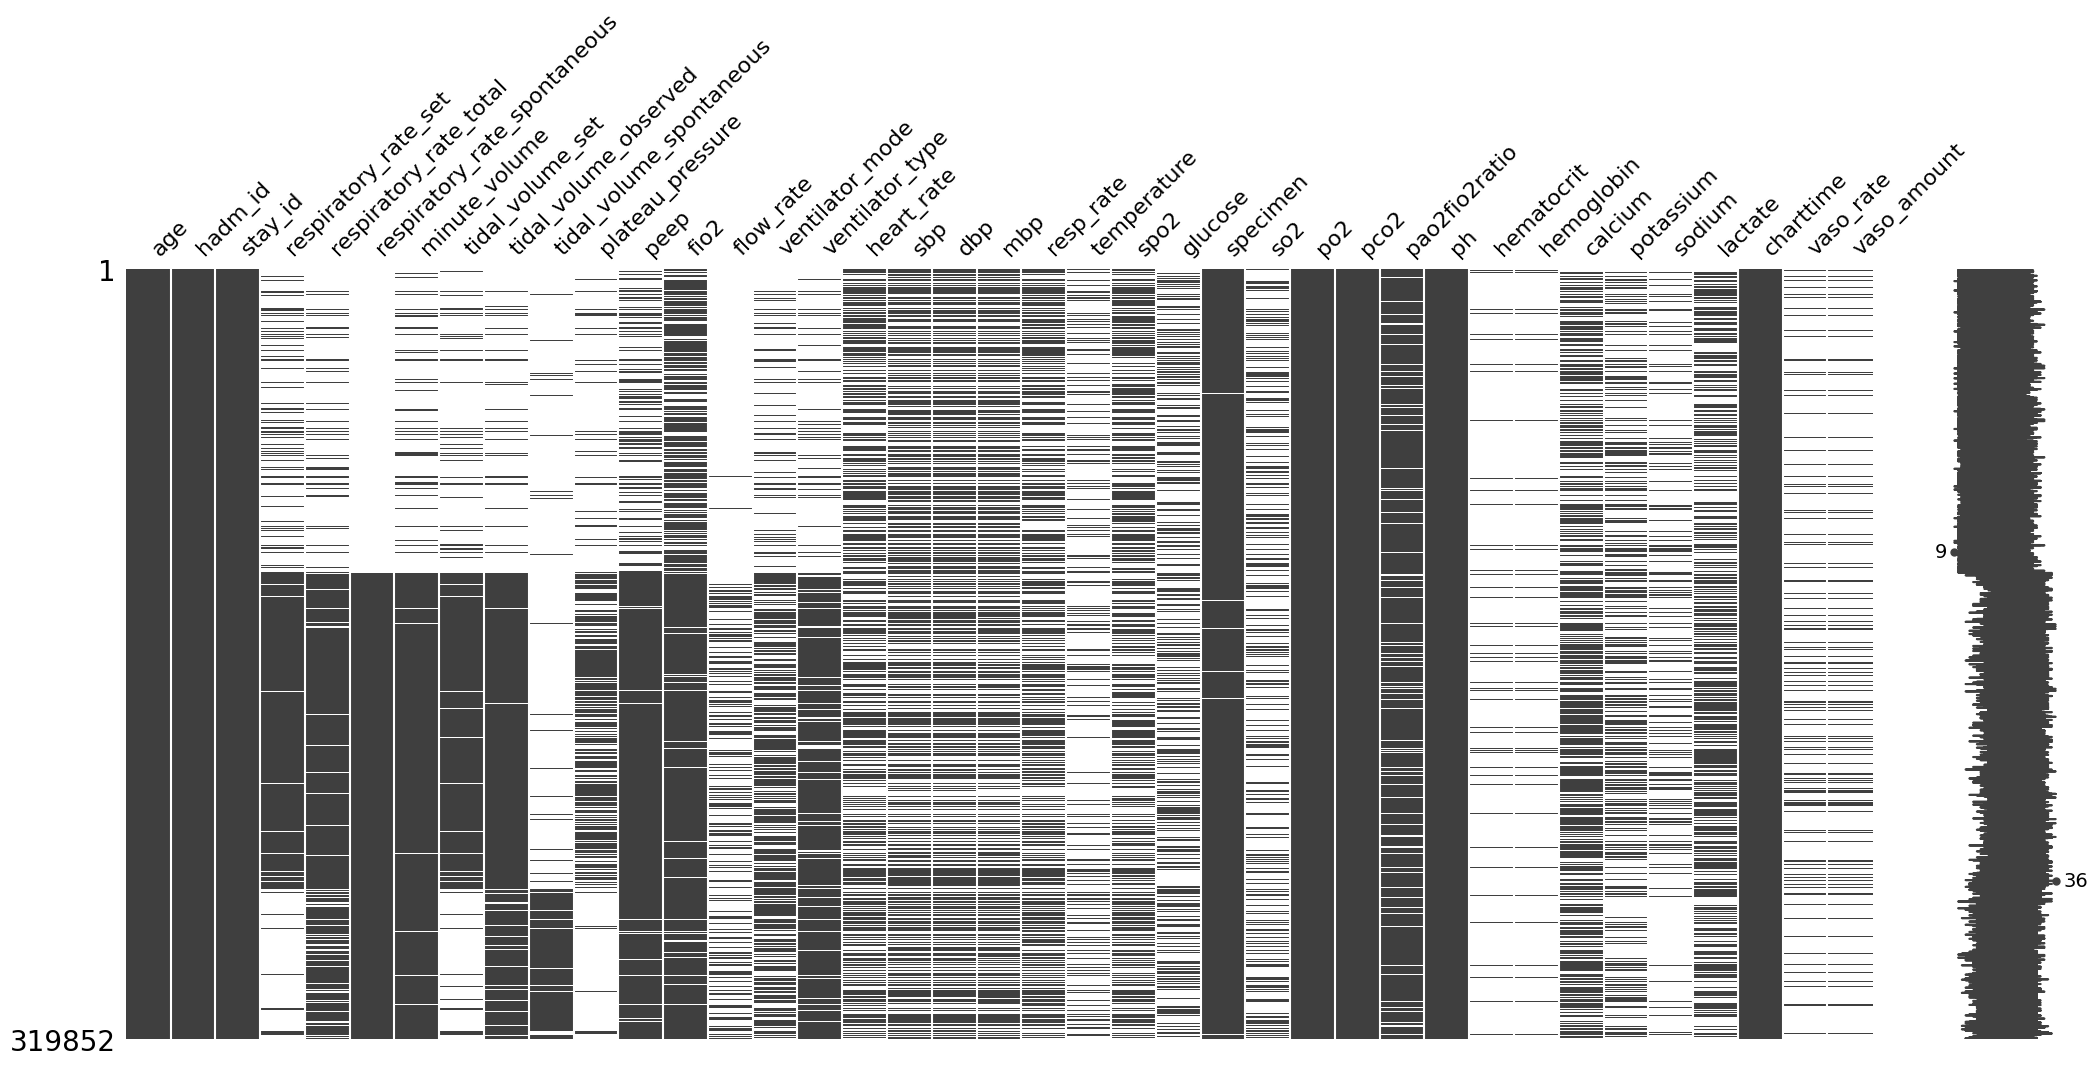

In [ ]:
import missingno as msno

msno.matrix(dataset)

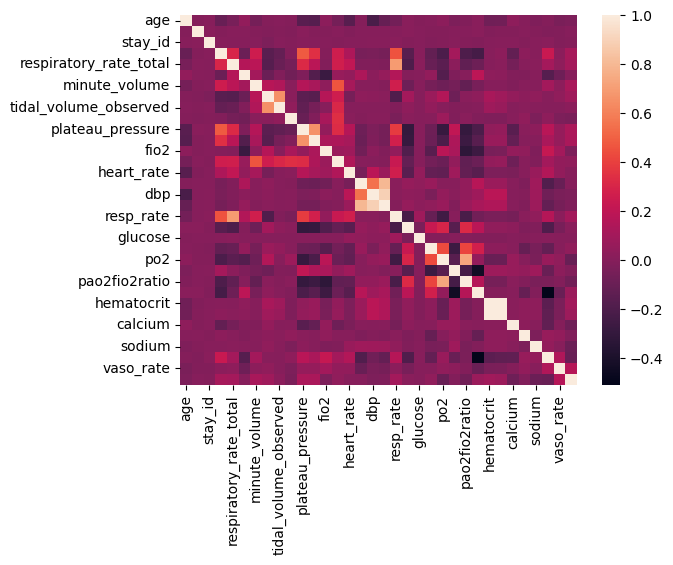

In [ ]:
corr_matrix = dataset._get_numeric_data().corr()
sns.heatmap(corr_matrix)
plt.show()


#### Drop some columns
Drop those columns that have > 50% null values

In [8]:
n = len(dataset)
cols_to_drop = null_data[null_data['Count'] > 0.5 * n]['Parameter'].values
dataset = dataset.drop(columns=cols_to_drop)

In [9]:
cols_to_drop

array(['tidal_volume_set', 'tidal_volume_spontaneous', 'plateau_pressure',
       'flow_rate', 'ventilator_mode', 'temperature', 'glucose', 'so2',
       'hematocrit', 'hemoglobin', 'potassium', 'sodium', 'vaso_rate',
       'vaso_amount'], dtype=object)

In [10]:
len(dataset.columns)

25

#### Fill missing values using 'forward fill' method

In [11]:
dataset = dataset.fillna(method='ffill')

## Visualization

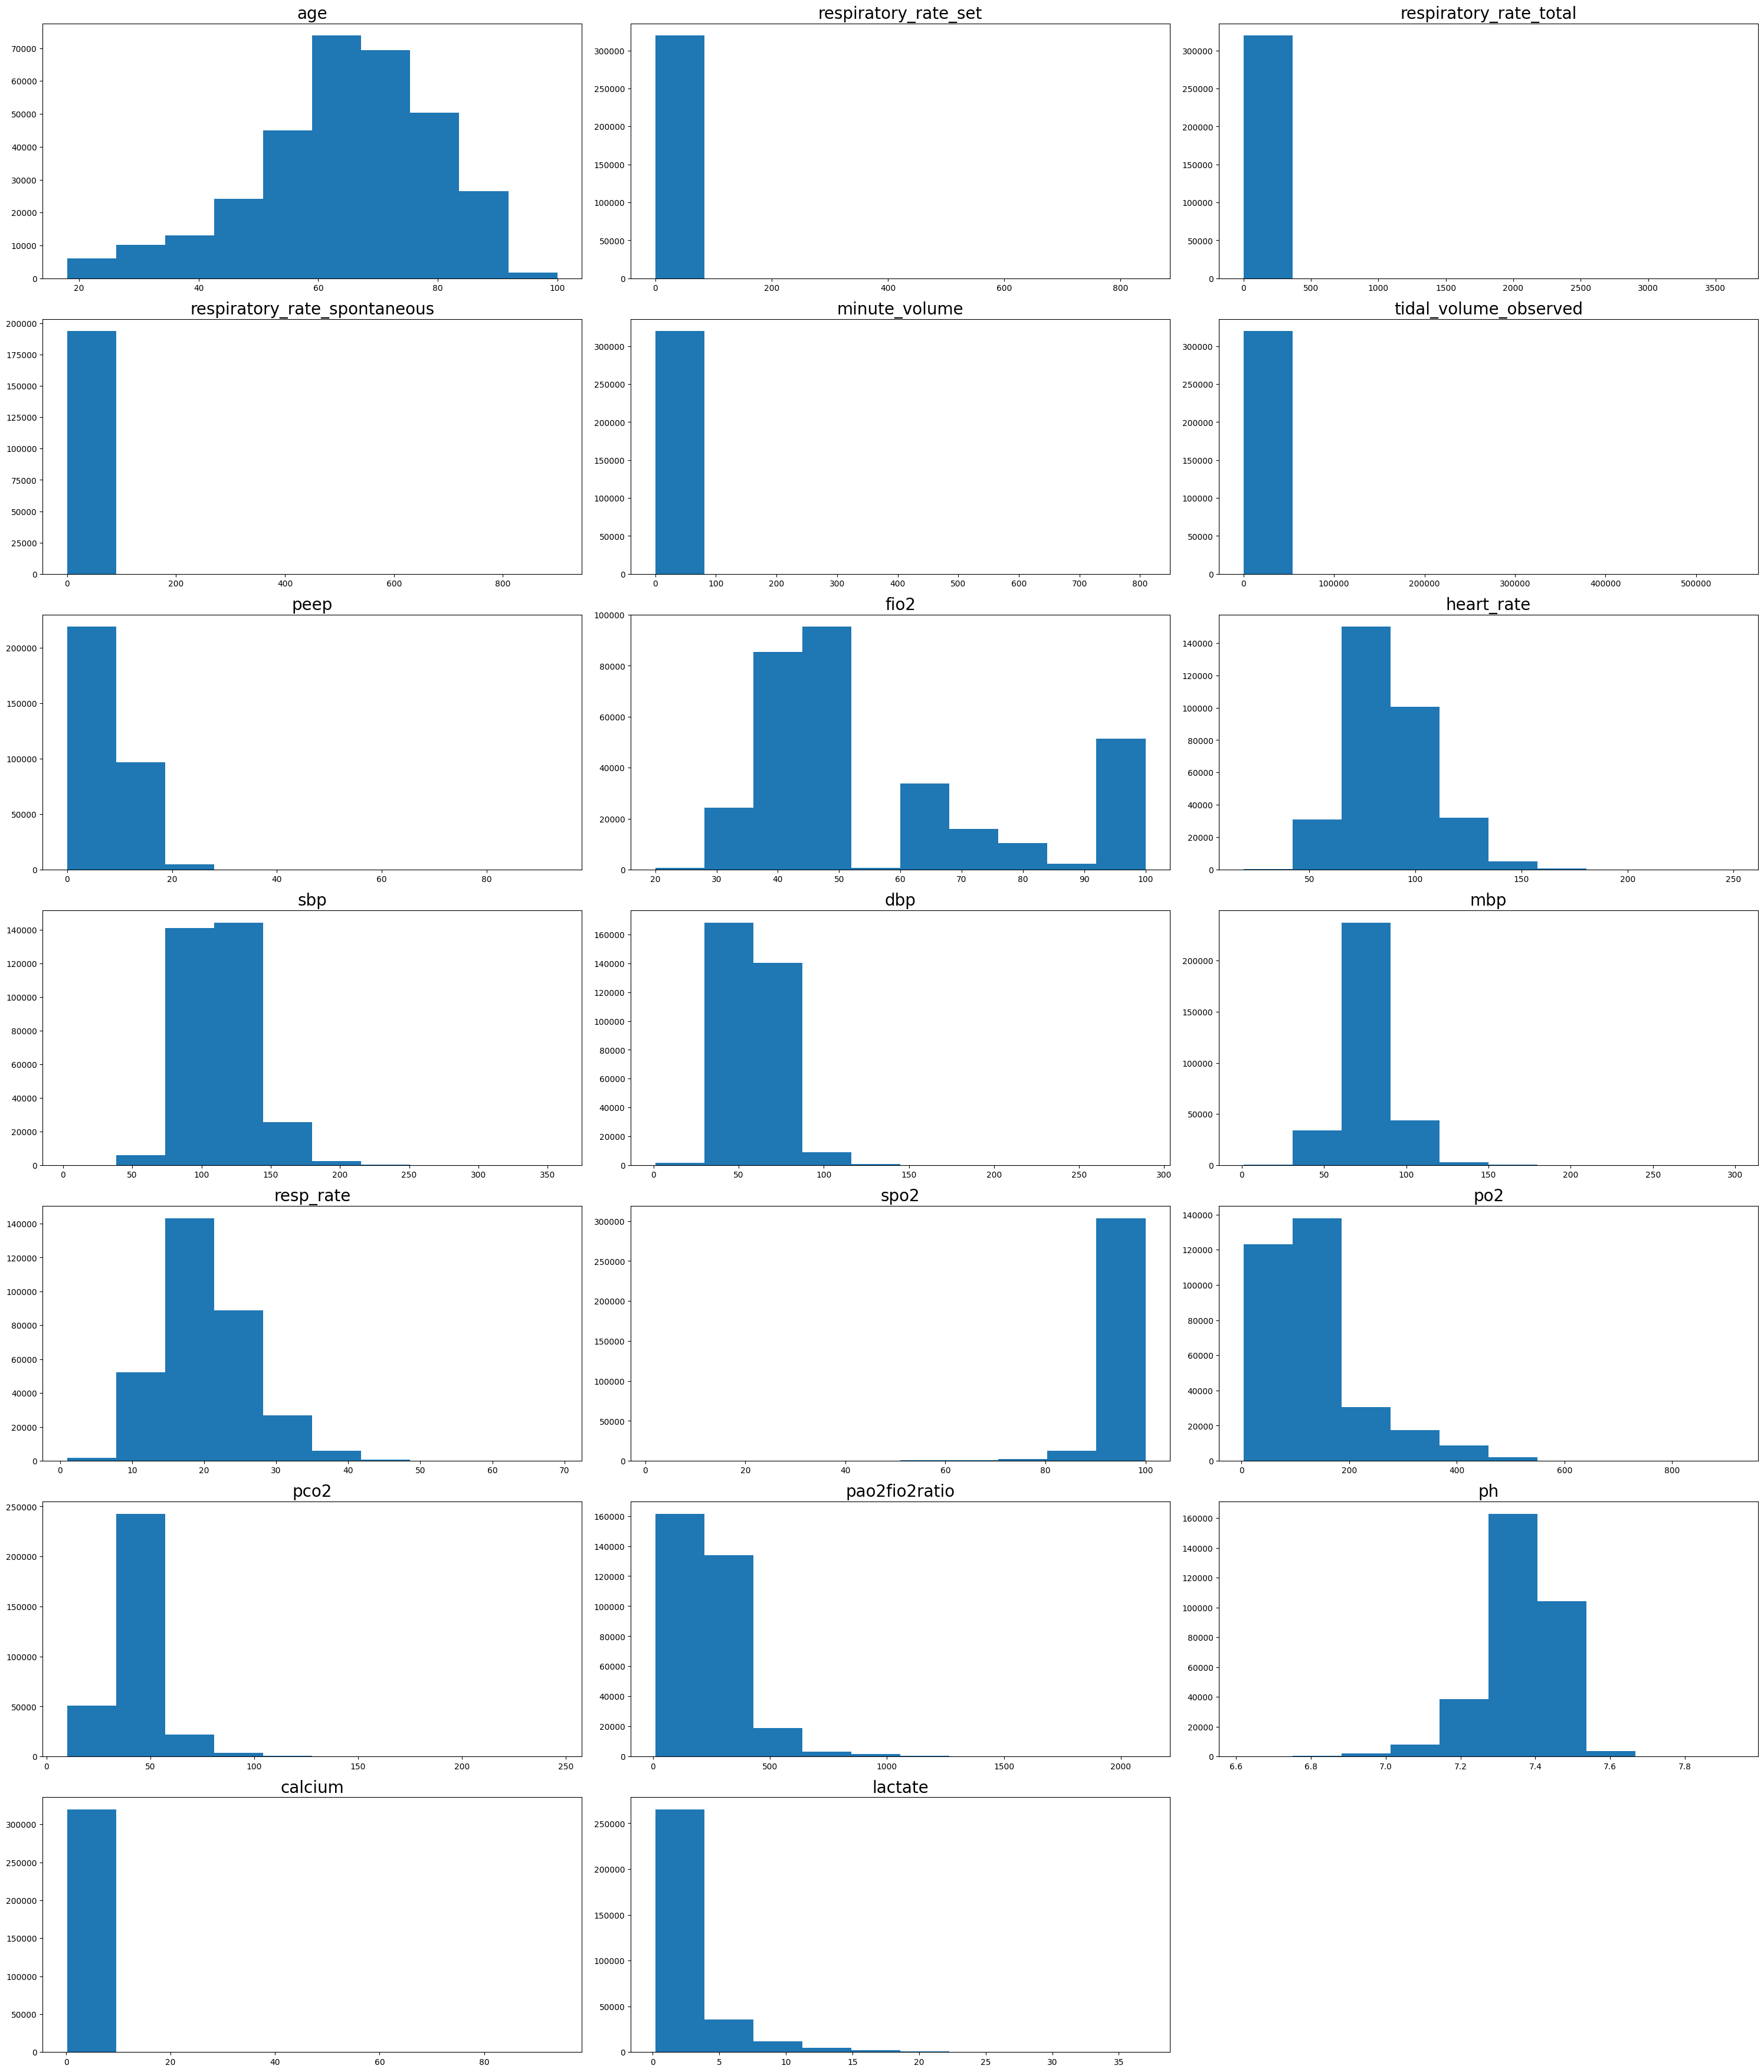

In [ ]:
def display_numeric_cols_freq(cols):
  n = len(cols)
  rows = math.ceil(n / 3)
  plot_count = 1
  plt.figure(figsize=(30, 5 * rows))
  for idx in range(n):
    if cols[idx] == 'hadm_id' or cols[idx] == 'stay_id':
      continue
    data = dataset[cols[idx]].dropna().values
    counts, bins = np.histogram(data)
    plt.subplot(rows, 3, plot_count)
    plt.hist(bins[:-1], bins, weights=counts)
    plt.title(cols[idx], fontsize=20)
    plot_count += 1
  plt.tight_layout()

display_numeric_cols_freq(dataset._get_numeric_data().columns)

In [ ]:
def get_categorical_cols(all_cols):
  num_cols = dataset._get_numeric_data().columns
  categorical = list(set(all_cols) - set(num_cols))
  return categorical

get_categorical_cols(dataset.columns)

['charttime', 'specimen', 'ventilator_type']

In [12]:
categorical_cols = [
    'specimen',
    'ventilator_type'
]

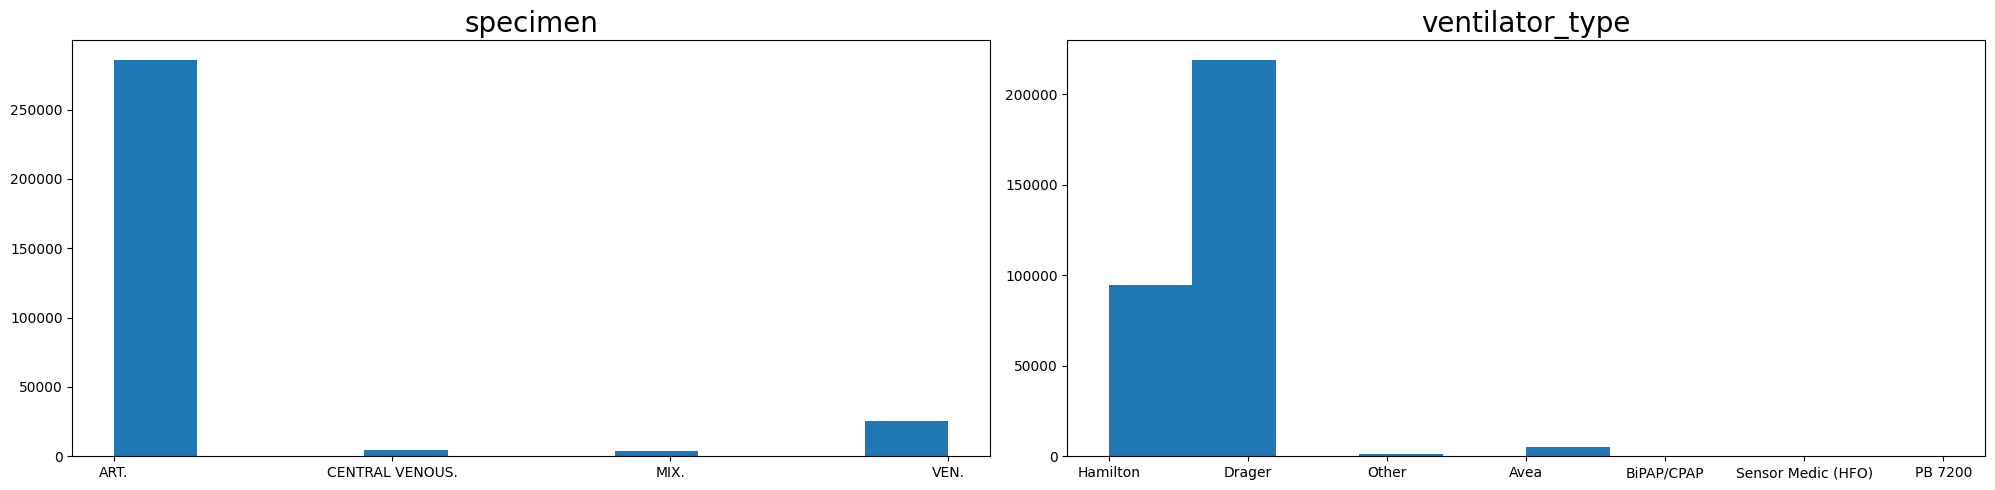

In [ ]:
def display_categorical_cols_freq(cols):
  n = len(cols)
  rows = math.ceil(n / 3)
  plot_count = 1
  plt.figure(figsize=(30, 5 * rows))
  for idx in range(n):
    data = dataset[cols[idx]].dropna().values
    plt.subplot(rows, 3, plot_count)
    plt.hist(data)
    plt.title(cols[idx], fontsize=20)
    plot_count += 1
  plt.tight_layout()

display_categorical_cols_freq(categorical_cols)

## Remove outliers

In [13]:
def remove_outliers(colname):
  Q1 = np.percentile(dataset[colname], 20,
                   method = 'midpoint')
  Q3 = np.percentile(dataset[colname], 80,
                    method = 'midpoint')
  IQR = Q3 - Q1
  
  # Upper bound
  upper=Q3+1.5*IQR
  upper_array=np.where(dataset[colname]>upper)
  # Lower bound
  lower=Q1-1.5*IQR
  lower_array=np.where(dataset[colname]<=lower)

  # Removing the outliers
  # dataset.drop(upper_array[0],inplace=True)
  dataset.loc[upper_array[0], colname]=IQR
  dataset.loc[lower_array[0], colname]=IQR

In [14]:
for colname in dataset._get_numeric_data().columns:
  if colname =='hadm_id' or colname =='age' or colname =='stay_id':
    continue
  else:
    remove_outliers(colname)

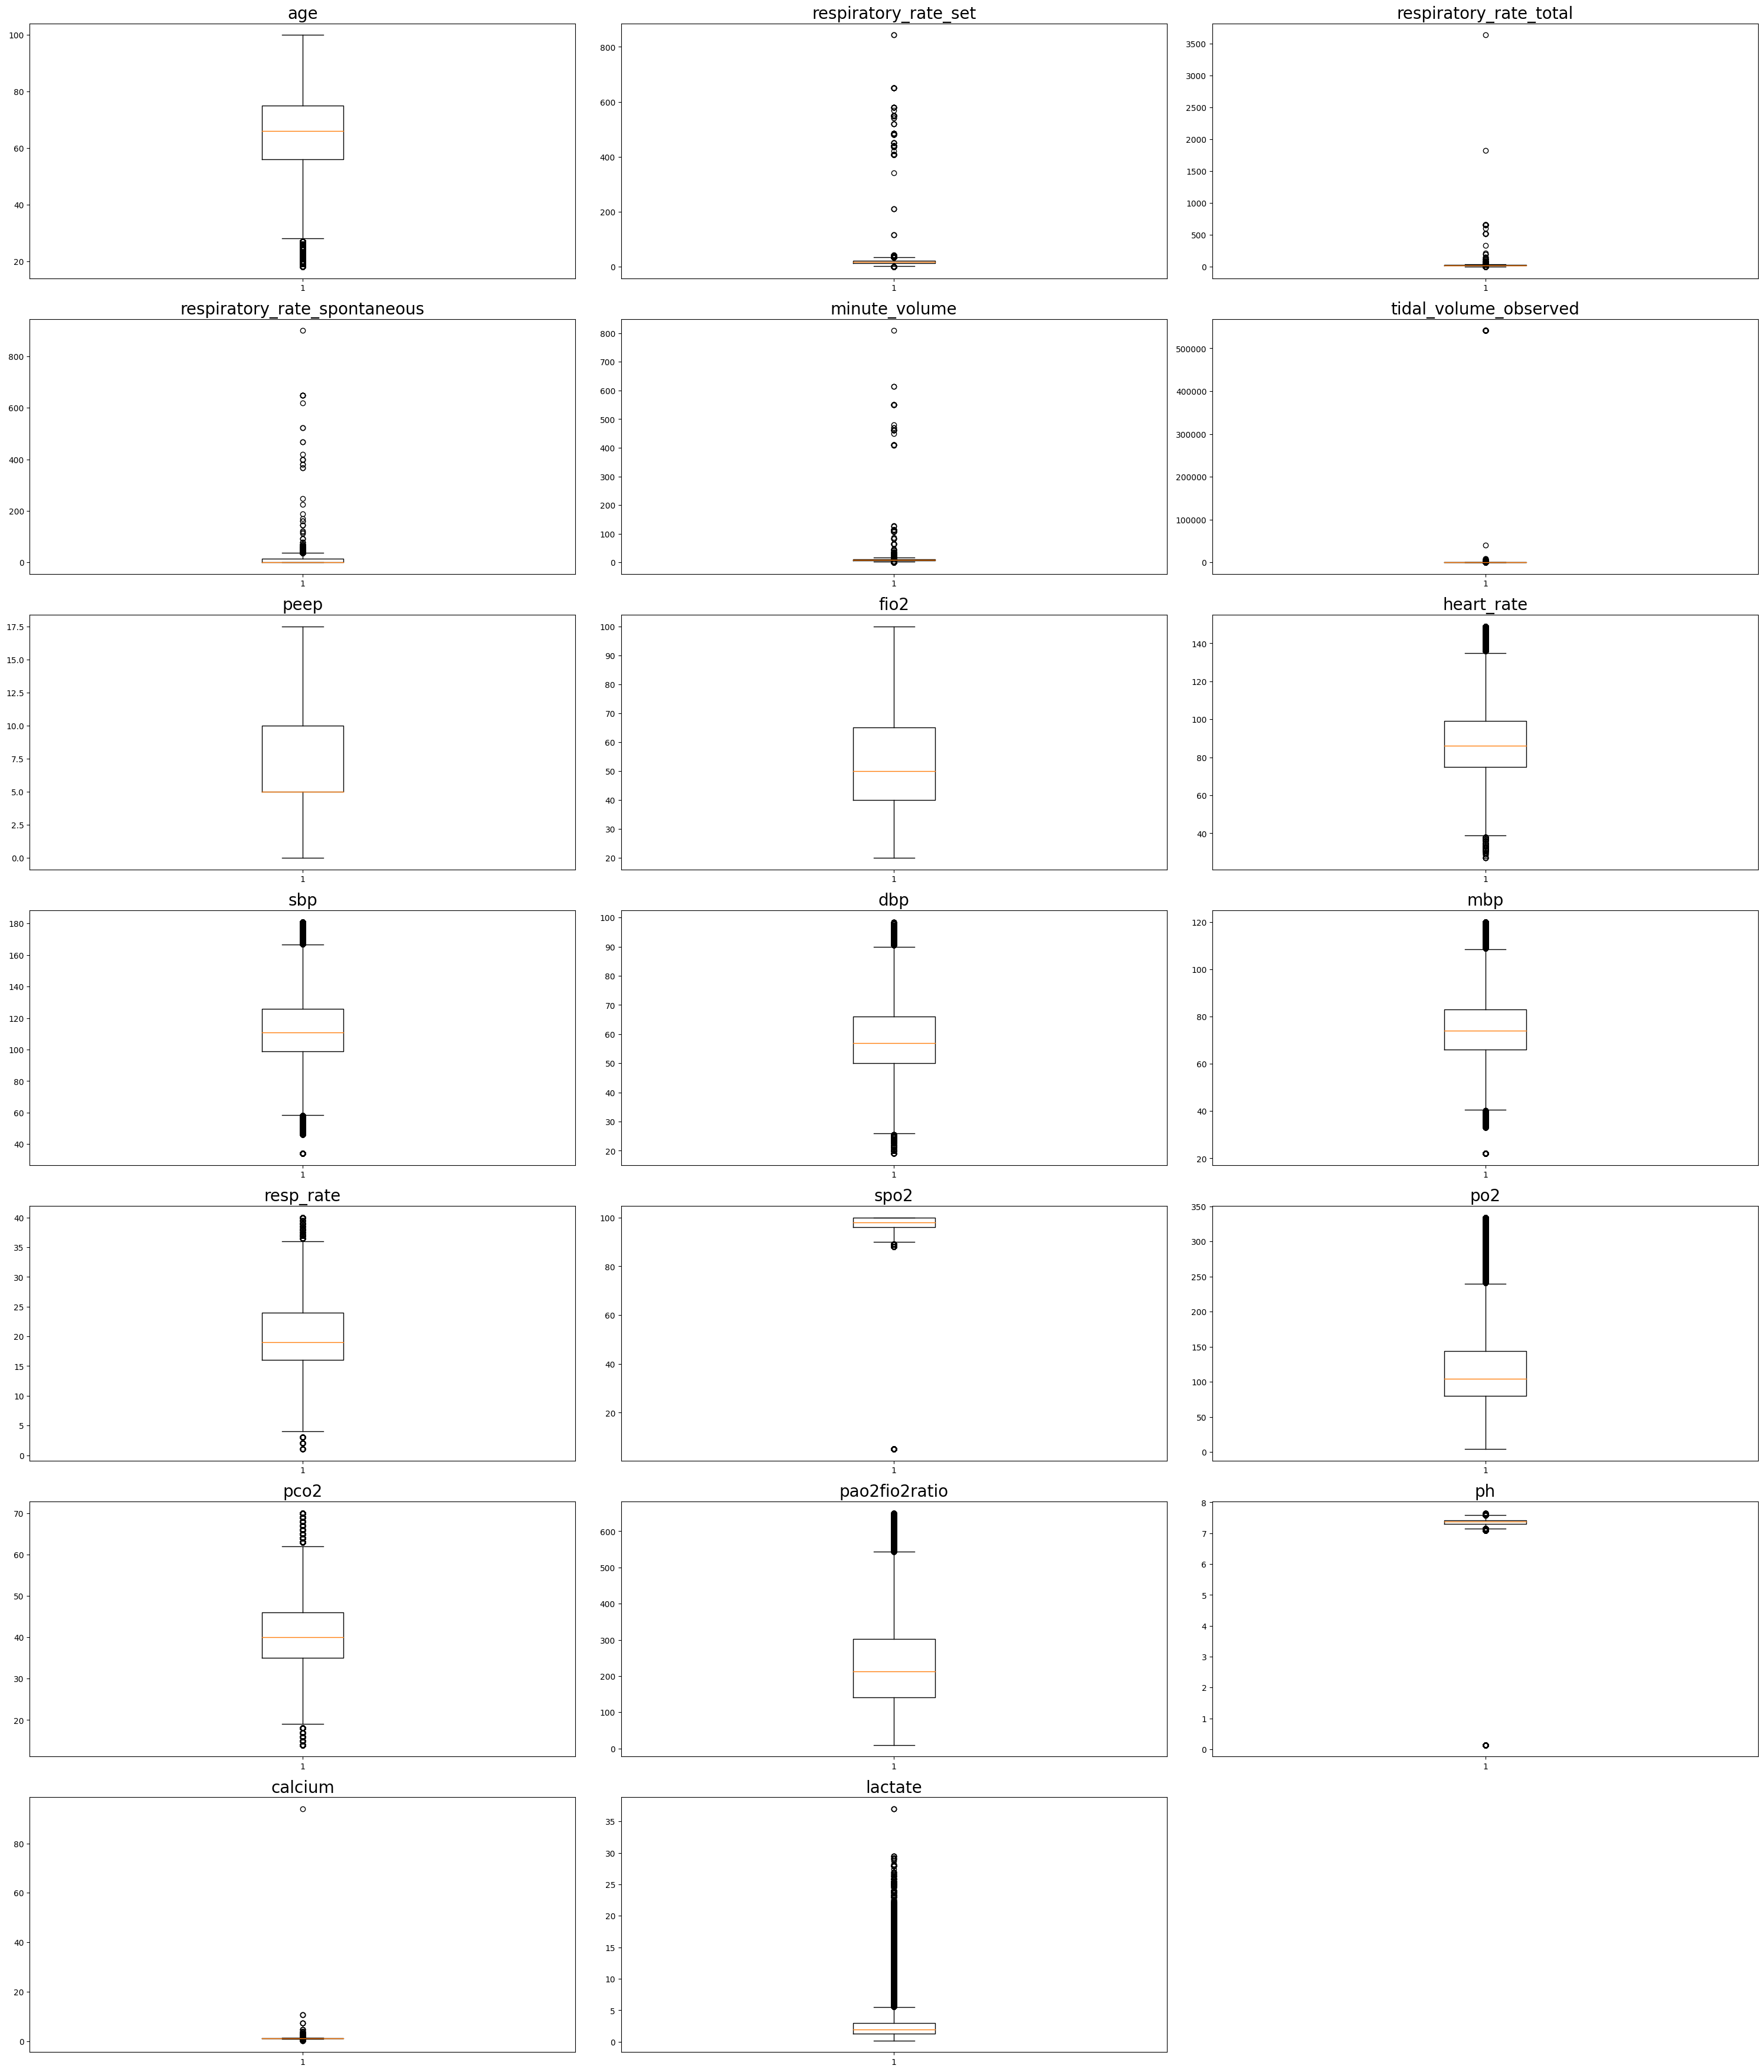

In [15]:
def display_box_plot(cols):
  n = len(cols)
  rows = math.ceil(n / 3)
  plot_count = 1
  plt.figure(figsize=(30, 5 * rows))
  for idx in range(n):
    if cols[idx] == 'hadm_id' or cols[idx] == 'stay_id':
      continue
    data = dataset[cols[idx]].dropna().values
    plt.subplot(rows, 3, plot_count)
    plt.boxplot(data)
    plt.title(cols[idx], fontsize=20)
    plot_count += 1
  plt.tight_layout()

display_box_plot(dataset._get_numeric_data().columns)

## One-Hot-Encode the categorical values

In [ ]:
categorical_cols = [
    'specimen',
    'ventilator_type'
]

In [16]:
samples_all = dataset
for col in categorical_cols:
  samples_all = pd.concat(
      [
        samples_all,
        pd.get_dummies(dataset[col])
      ],
      axis=1
  )
  samples_all.drop(columns=[col], inplace=True)

### Selection of relevant parameters

In [17]:
cols_eliminated = []
samples_all = samples_all.drop(columns=cols_eliminated)

### Order all samples by their `stay_id`s, then by their `c_time`s

In [18]:
samples_grouped = samples_all.groupby(by='stay_id')
grouped_and_sorted = []
for name, group in samples_grouped.__iter__():
  # consider only those records that have at least 10 samples
  if (len(group) > 10):
    grouped_and_sorted.append(group.sort_values(by='charttime').reset_index(drop=True))

### Prepare the training set

In [19]:
def find_onset_time(stay):
  idx = 0
  for index, row in stay.iterrows():
    if row['peep'] >= 5 and row['pao2fio2ratio'] < 300:
      return idx
    idx += 1
  return -1

In [20]:
def do_resampling(df):
  df = df.set_index('charttime')
  df = df.resample('120min').median()  
  return df.fillna(method='ffill')

In [21]:
for idx in range(len(grouped_and_sorted)):
  grouped_and_sorted[idx] = do_resampling(grouped_and_sorted[idx])
  grouped_and_sorted[idx].drop(columns=['hadm_id', 'stay_id'], inplace=True)

In [22]:
count = 0
col_ = set()
cols = grouped_and_sorted[0].columns
for g in grouped_and_sorted:
  for col in cols:
    if g[col].isna().sum() != 0:
      col_.add(col)
      count += 1
      break
print(count)

2875


In [23]:
col_

{'respiratory_rate_spontaneous', 'respiratory_rate_total'}

In [24]:
for idx in range(len(grouped_and_sorted)):
  grouped_and_sorted[idx].drop(columns=['respiratory_rate_spontaneous', 'respiratory_rate_total'], inplace=True)

In [25]:
import math

# returns the (integer) hours difference between the 2 timestamps 
def hours_diff(t1, t2):
  diff = math.floor(
      (t2 - t1).total_seconds() / 3600
  )
  return diff

In [26]:
def make_samples(pred_window=12, bound=48):
  positive = []
  negative = []
  count = 0
  for group in grouped_and_sorted:
    onset_time_index = find_onset_time(group)
    if onset_time_index != -1:
      onset_time = group.index[onset_time_index]
      # number of hours before the onset time for which data is available
      n_hours = hours_diff(group.index[0], group.index[onset_time_index])
      start = 0
      if n_hours > bound:
        start = (n_hours - bound) // 2
      if (onset_time_index - start + 1) > pred_window / 2:
        end_negative = (onset_time_index - start + 1) - pred_window // 2
        negative.append(group.iloc[start:end_negative])
        start = end_negative
      positive.append(group.iloc[start:onset_time_index])
    # alternate code
    # if onset_time_index != -1:
    #   onset_time = group.iloc[onset_time_index].name
    #   start = 0
    #   idx = 0
    #   for i in range(onset_time_index):
    #     duration = group.index[onset_time_index] - group.index[i]
    #     duration = duration.total_seconds() / 3600
    #     if duration > bound:  # ignore all measurements greater than 24-hours prior to onset
    #       start += 1
    #     if duration <= pred_window:
    #       idx = i
    #       break  # consider all measurements 12-hours prior to onset
    #   if onset_time_index - idx > 0:
    #     positive.append(group.iloc[idx:onset_time_index])
    #   if idx - start > 0:
    #     negative.append(group.iloc[start:idx])
    else:
      negative.append(group)
  print("{} {}".format(len(positive), len(negative)))
  return positive, negative

In [27]:
def make_rnn_samples(samples, lookback):
  rnn_samples = []
  for sample in samples:
    n = len(sample)
    for i in range(n - lookback):
      rnn_samples.append(sample.iloc[i: i + lookback])
  return rnn_samples

In [28]:
positive, negative = make_samples(18)

positives_ = positive
negatives_ = negative

lookback = 6
positive_rnn = make_rnn_samples(positives_, lookback)
negative_rnn = make_rnn_samples(negatives_, lookback)
print("No. of positive samples: {}".format(len(positive_rnn)))
print("No. of negative samples: {}".format(len(negative_rnn)))

8659 943
No. of positive samples: 9674
No. of negative samples: 6519


In [29]:
rnn_samples_all = positive_rnn + negative_rnn
labels_all = [1 for i in range(len(positive_rnn))] + [0 for i in range(len(negative_rnn))]

## Get training records

In [30]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X, y = shuffle(rnn_samples_all, labels_all)

In [31]:
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
X_train_s = np.array([scalar.fit_transform(x) for x in X_train]).astype(np.float32)
X_test_s = np.array([scalar.fit_transform(x) for x in X_test]).astype(np.float32)

In [33]:
y_train = np.array(y_train).astype(np.int32)
y_test = np.array(y_test).astype(np.int32)

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

In [35]:
# parameters
n_inputs = X_train[0].shape[1]  # number of features
n_neurons = 50
n_outputs = 2
n_layers = 2
batch_size = 28
n_epochs = 25

## RNN

In [36]:
RNNcells = [tf.keras.layers.SimpleRNNCell(n_neurons) for _ in range(n_layers)]
rnn = tf.keras.layers.StackedRNNCells(RNNcells, input_shape = (5, n_inputs))
RNNmodel = Sequential()
RNNmodel.add(layers.RNN(rnn))
RNNmodel.add(layers.Dense(64, activation='relu'))
RNNmodel.add(layers.Dense(n_outputs, activation='softmax'))

In [37]:
RNNmodel.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [38]:
RNNhistory=RNNmodel.fit(
    X_train_s,
    y_train,
    validation_data=(X_test_s, y_test), 
    batch_size=batch_size, 
    epochs=n_epochs,
)

Epoch 1/25
405/405 [==============================] - 5s 7ms/step - loss: 0.6588 - accuracy: 0.6283 - val_loss: 0.6392 - val_accuracy: 0.6554
Epoch 2/25
405/405 [==============================] - 2s 6ms/step - loss: 0.6522 - accuracy: 0.6372 - val_loss: 0.6361 - val_accuracy: 0.6571
Epoch 3/25
405/405 [==============================] - 3s 8ms/step - loss: 0.6452 - accuracy: 0.6461 - val_loss: 0.6356 - val_accuracy: 0.6583
Epoch 4/25
405/405 [==============================] - 2s 5ms/step - loss: 0.6402 - accuracy: 0.6538 - val_loss: 0.6378 - val_accuracy: 0.6606
Epoch 5/25
405/405 [==============================] - 3s 6ms/step - loss: 0.6326 - accuracy: 0.6615 - val_loss: 0.6448 - val_accuracy: 0.6618
Epoch 6/25
405/405 [==============================] - 2s 6ms/step - loss: 0.6283 - accuracy: 0.6655 - val_loss: 0.6365 - val_accuracy: 0.6585
Epoch 7/25
405/405 [==============================] - 2s 6ms/step - loss: 0.6186 - accuracy: 0.6732 - val_loss: 0.6401 - val_accuracy: 0.6595
Epoch 

###Hyper Parameter Tuning

In [ ]:
!pip install keras-tuner
import kerastuner as kt
def model_builder(hp):
  # Initialize the Sequential API and start stacking the layers
  model = keras.Sequential()
  model.add(keras.layers.Flatten((5, n_inputs)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_1'))

  # Add next layers
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(10, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
  return model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import keras
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='dir',
                     project_name='khyperband')
# hypertuning settings
tuner.search_space_summary() 

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(X_train_s, y_train, epochs=10, validation_split=0.2)
best_hp=tuner.get_best_hyperparameters()[0]


Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
256               |352               |units
0.0001            |0.0001            |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/tuner.py", line 155, in _try_build
    model = self._bui

RuntimeError: ignored

## LSTM

In [39]:
LSTMcells = [tf.keras.layers.LSTMCell(n_neurons) for _ in range(n_layers)]
lstm = tf.keras.layers.StackedRNNCells(LSTMcells, input_shape = (5, n_inputs))
LSTMmodel = Sequential()
LSTMmodel.add(layers.RNN(lstm))
LSTMmodel.add(layers.Dense(64, activation='relu'))
LSTMmodel.add(layers.Dense(n_outputs, activation='softmax'))

In [40]:
LSTMmodel.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [42]:
LSTMhistory = LSTMmodel.fit(
    X_train_s,
    y_train,
    validation_data=(X_test_s, y_test), 
    batch_size=batch_size, 
    epochs=n_epochs,
)

Epoch 1/25
405/405 [==============================] - 6s 15ms/step - loss: 0.4736 - accuracy: 0.7544 - val_loss: 0.7258 - val_accuracy: 0.7100
Epoch 2/25
405/405 [==============================] - 5s 12ms/step - loss: 0.4631 - accuracy: 0.7586 - val_loss: 0.7691 - val_accuracy: 0.7116
Epoch 3/25
405/405 [==============================] - 5s 13ms/step - loss: 0.4623 - accuracy: 0.7581 - val_loss: 0.7569 - val_accuracy: 0.7122
Epoch 4/25
405/405 [==============================] - 5s 13ms/step - loss: 0.4561 - accuracy: 0.7613 - val_loss: 0.8087 - val_accuracy: 0.7114
Epoch 5/25
405/405 [==============================] - 5s 12ms/step - loss: 0.4671 - accuracy: 0.7562 - val_loss: 0.7564 - val_accuracy: 0.7122
Epoch 6/25
405/405 [==============================] - 6s 14ms/step - loss: 0.4540 - accuracy: 0.7614 - val_loss: 0.7853 - val_accuracy: 0.7133
Epoch 7/25
405/405 [==============================] - 5s 11ms/step - loss: 0.4669 - accuracy: 0.7569 - val_loss: 0.7731 - val_accuracy: 0.7165

## GRU

In [43]:
GRUcells = [tf.keras.layers.GRUCell(n_neurons) for _ in range(n_layers)]
gru = tf.keras.layers.StackedRNNCells(GRUcells, input_shape = (5, n_inputs))
GRUmodel = Sequential()
GRUmodel.add(layers.RNN(gru))
GRUmodel.add(layers.Dense(64, activation='relu'))
GRUmodel.add(layers.Dense(n_outputs, activation='softmax'))

In [44]:
GRUmodel.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [45]:
GRUhistory = GRUmodel.fit(
    X_train_s,
    y_train,
    validation_data=(X_test_s, y_test), 
    batch_size=batch_size, 
    epochs=n_epochs,
)

Epoch 1/25
405/405 [==============================] - 9s 13ms/step - loss: 0.6565 - accuracy: 0.6298 - val_loss: 0.6422 - val_accuracy: 0.6540
Epoch 2/25
405/405 [==============================] - 5s 13ms/step - loss: 0.6509 - accuracy: 0.6411 - val_loss: 0.6377 - val_accuracy: 0.6569
Epoch 3/25
405/405 [==============================] - 5s 13ms/step - loss: 0.6470 - accuracy: 0.6456 - val_loss: 0.6366 - val_accuracy: 0.6536
Epoch 4/25
405/405 [==============================] - 5s 12ms/step - loss: 0.6426 - accuracy: 0.6516 - val_loss: 0.6409 - val_accuracy: 0.6651
Epoch 5/25
405/405 [==============================] - 6s 15ms/step - loss: 0.6384 - accuracy: 0.6530 - val_loss: 0.6324 - val_accuracy: 0.6649
Epoch 6/25
405/405 [==============================] - 5s 11ms/step - loss: 0.6299 - accuracy: 0.6632 - val_loss: 0.6345 - val_accuracy: 0.6711
Epoch 7/25
405/405 [==============================] - 6s 14ms/step - loss: 0.6232 - accuracy: 0.6691 - val_loss: 0.6234 - val_accuracy: 0.6762

## t-SNE Plot

In [46]:
np.array(X_train).shape

(11335, 6, 29)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=250)
tsne_pca_results = tsne.fit_transform(np.array(X_train).reshape(9770, 27*5))

ValueError: ignored

In [ ]:
tsne_df = pd.DataFrame(tsne_pca_results, columns=["tsne-2d-one", "tsne-2d-two"])

In [ ]:
tsne_df["y"] = y_train

In [ ]:
# plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

## Accuracy Plots

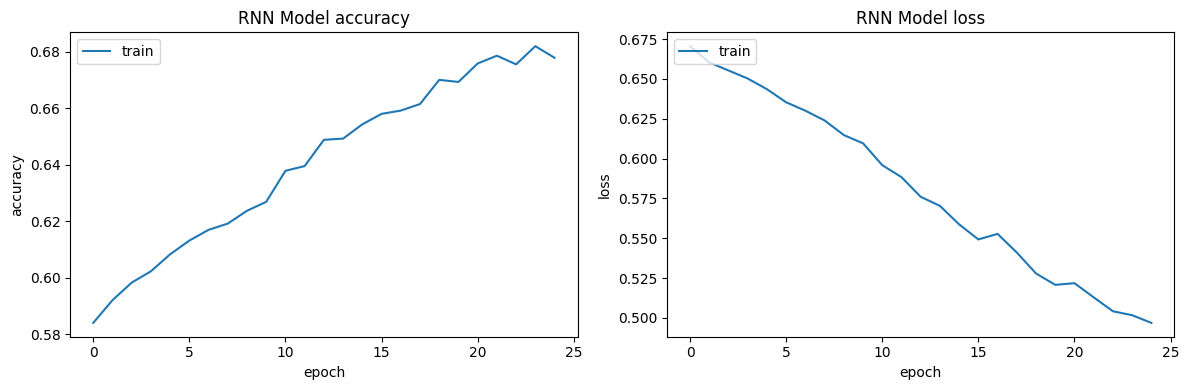

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
#plt.figure(figsize=(6,3))
plt.plot(RNNhistory.history['accuracy'])
plt.title('RNN Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')

plt.subplot(1,2,2)
#plt.figure(figsize=(6,3))
plt.plot(RNNhistory.history['loss'])
plt.title('RNN Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')

plt.tight_layout()

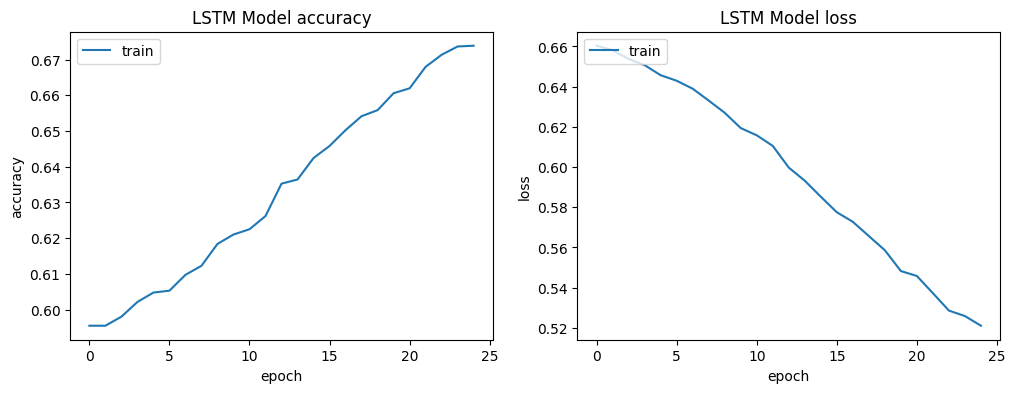

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(LSTMhistory.history['accuracy'])
plt.title('LSTM Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(LSTMhistory.history['loss'])
plt.title('LSTM Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')

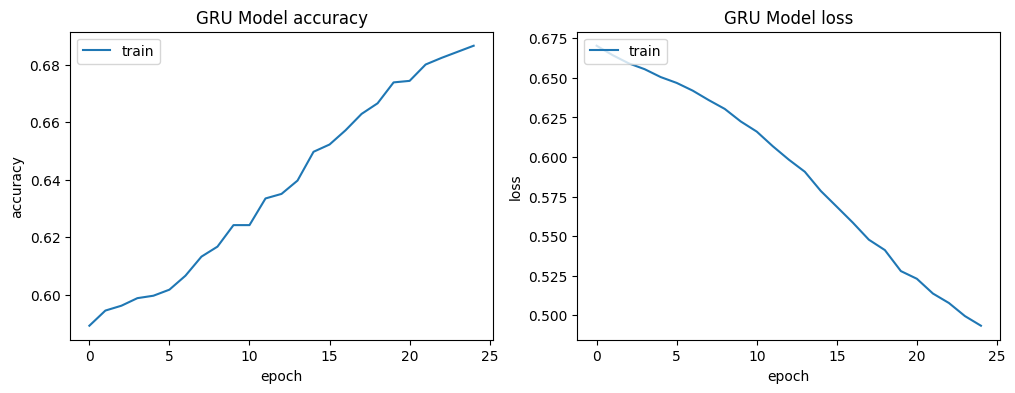

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(GRUhistory.history['accuracy'])
plt.title('GRU Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(GRUhistory.history['loss'])
plt.title('GRU Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
